# Dataset exploration

In this notebook I try to visualize every part of the dataset. This can help us understand the data, notice issues, and inform our choice of algorithm.

### Color images
We can see that these are images of a black cup taken in regular intervals.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.



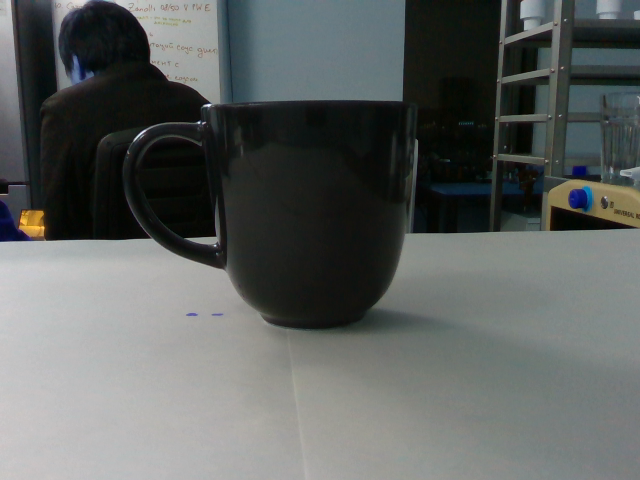
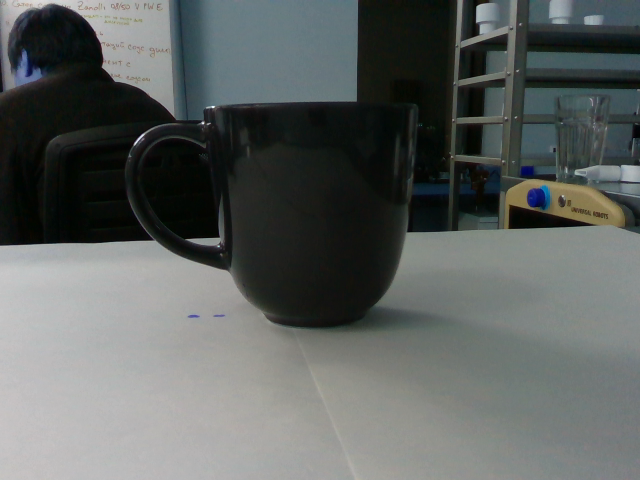
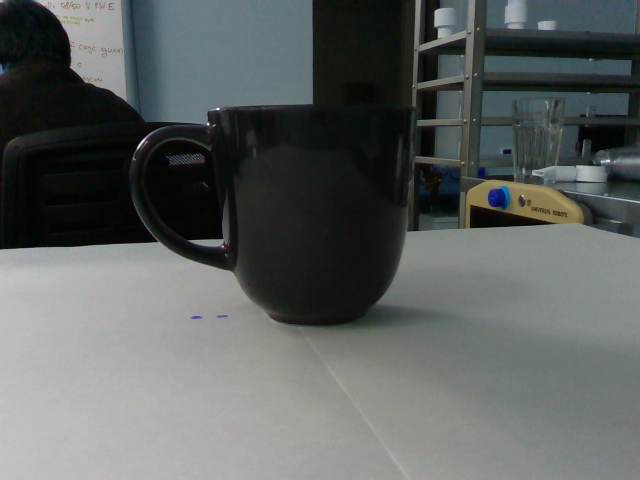
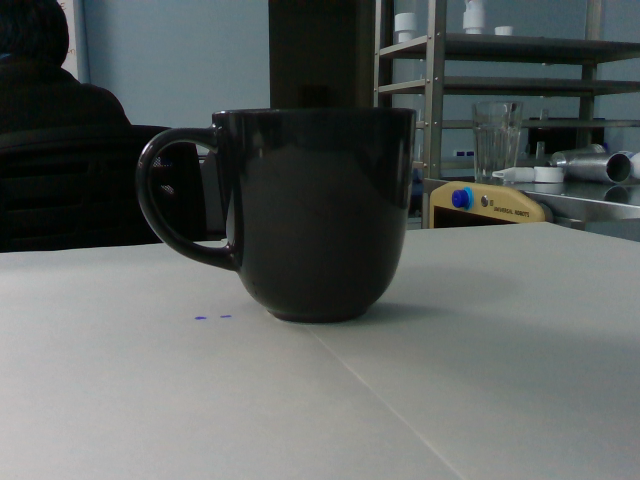
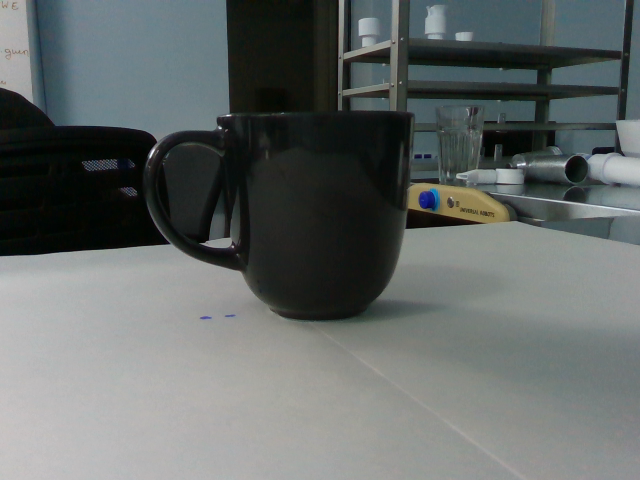


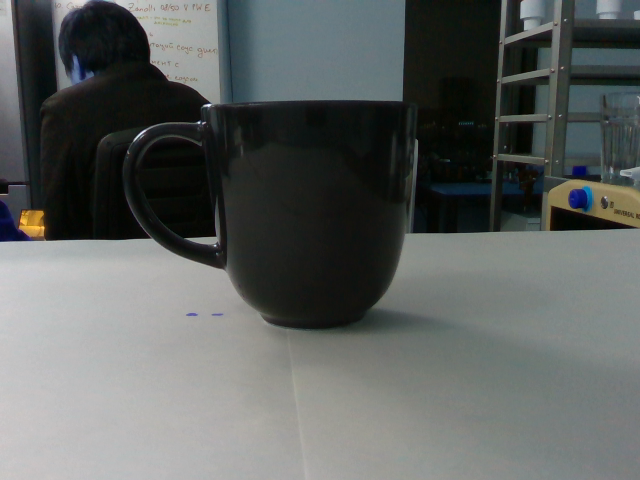
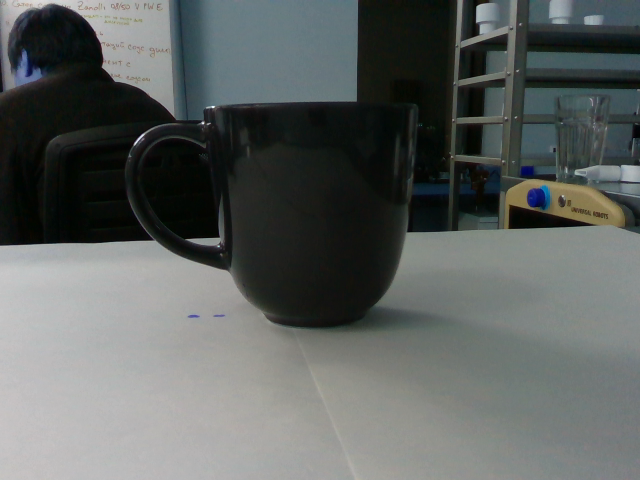
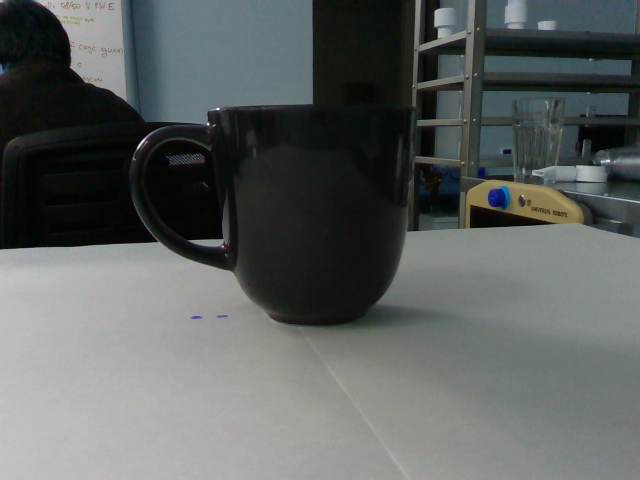
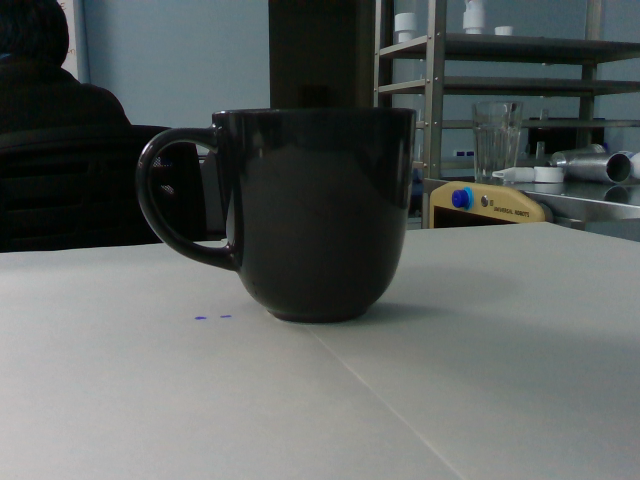
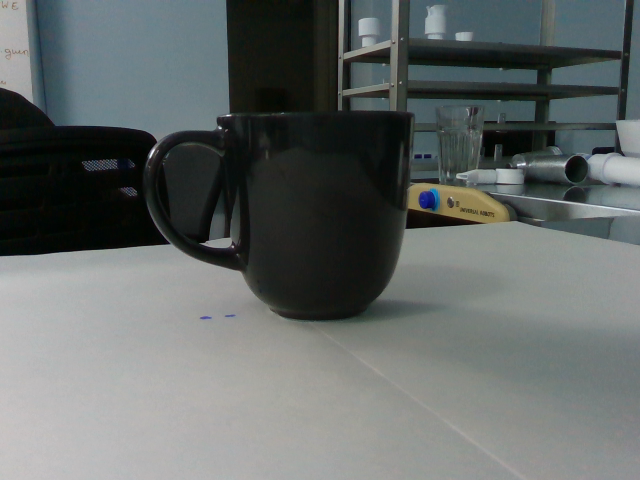

In [1]:
from reconstruction.dataset import Dataset
import ipyplot
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import reconstruction.utils.visualization as vis

dataset = Dataset.read("data/3d-scans-cap-black-glossy-ha-2019-02-27T16_06_29")

# Reduced so it can be visualized in Github
ipyplot.plot_images([cv2.imread(f.color_file) for f in dataset.frames], max_images=5)

### Depth images
We can see the typical D435 depth images, which have blobby appereance. It seems the most useful depth images are from frame 47 till the end


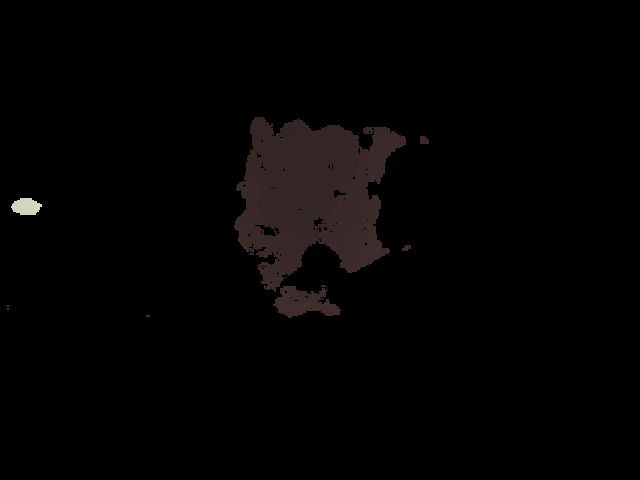
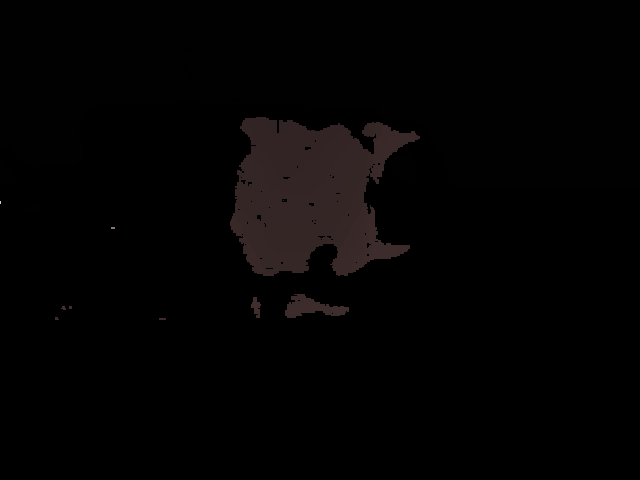
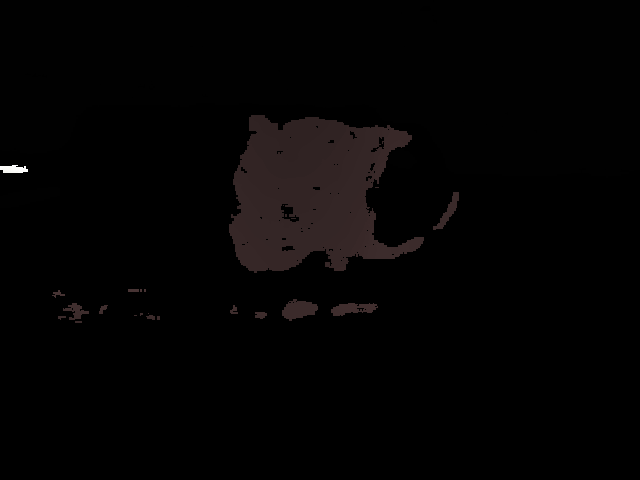
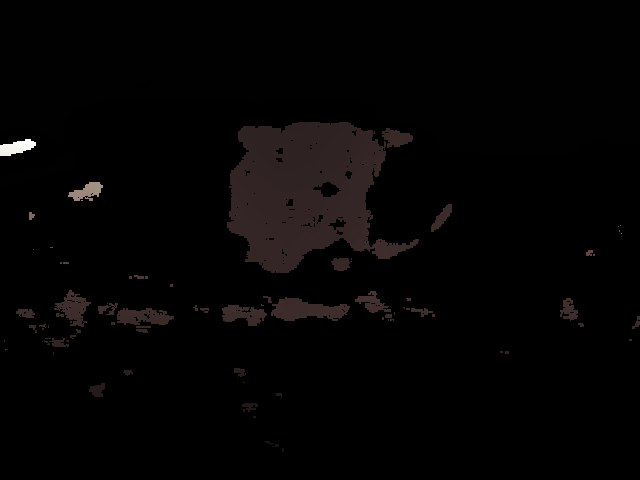
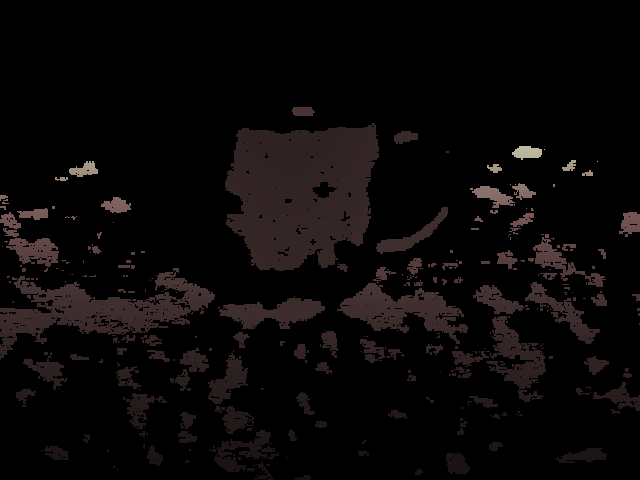


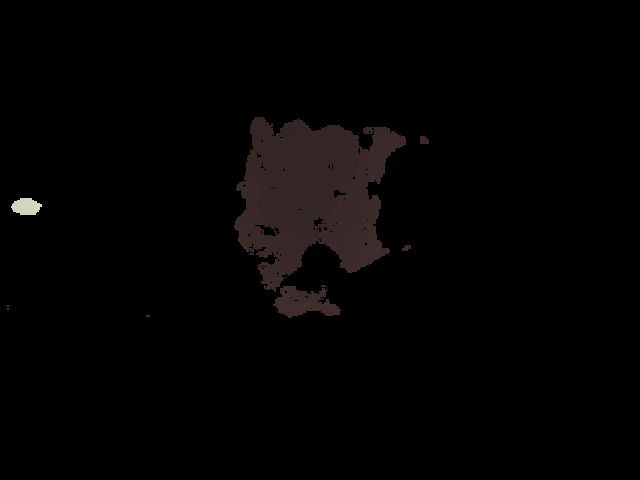
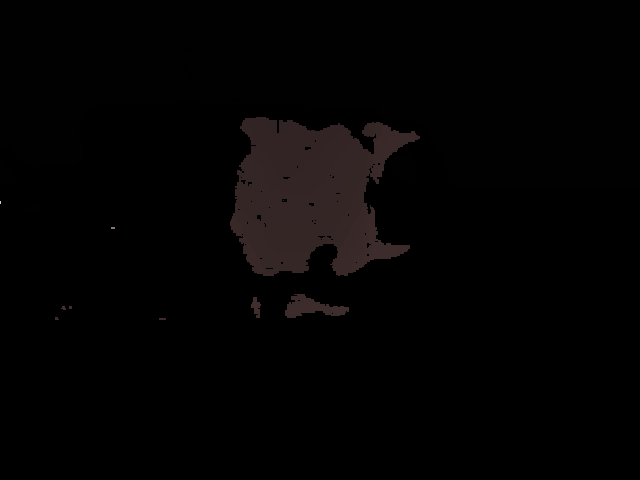
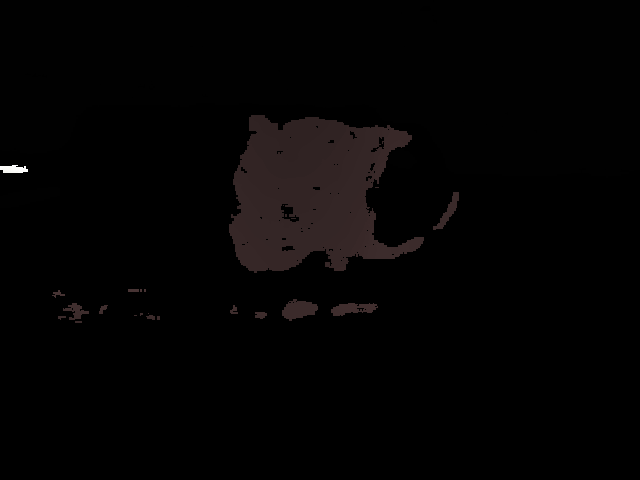
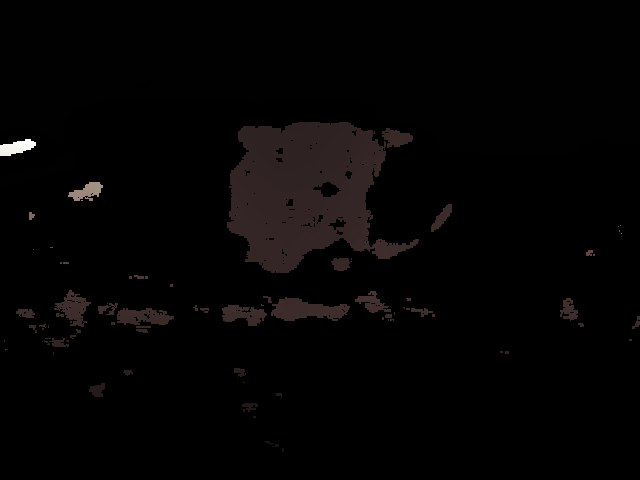
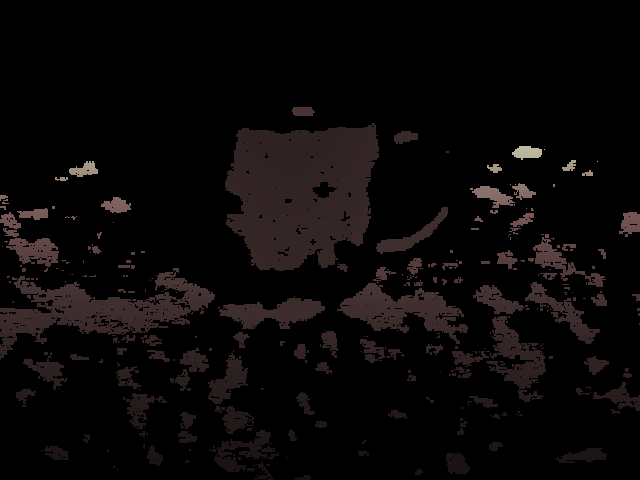

In [2]:
depth_images = [cv2.imread(frame.depth_file, cv2.IMREAD_ANYDEPTH) for frame in dataset.frames]

min_depth = 100
max_depth = 1000

# We clip the depth to have more color range in the depth we are interested in
colorized_depth_images = [image.clip(100, 1000) for image in depth_images]
colorized_depth_images = [cv2.normalize(image, None, 0, 65535, norm_type=cv2.NORM_MINMAX) for image in colorized_depth_images]
colorized_depth_images = [cv2.applyColorMap((image / 255).astype(np.uint8), cv2.COLORMAP_BONE) for image in colorized_depth_images]

# Reduced so it can be visualized in Github
ipyplot.plot_images(colorized_depth_images[40:70], max_images=5)

## Point cloud
We can extract a point cloud from the depth image using the camera intrinsic matrix. We can see that the the point clouds are blobby and have shadows behind objects.

In [3]:
import ipywidgets  as widgets

@widgets.interact(frame_id=(0, len(dataset.frames) - 1))
def draw_point_cloud(frame_id=52):
    color_image = o3d.io.read_image(dataset.frames[frame_id].color_file)
    depth_image = o3d.io.read_image(dataset.frames[frame_id].depth_file)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image, depth_image, depth_scale=1000.0, depth_trunc=0.5, convert_rgb_to_intensity=False)
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(640, 480, 613.688, 614.261, 323.035, 242.229)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        camera_intrinsic)

    vis.visualize_geometry([pcd], flip=True)

interactive(children=(IntSlider(value=52, description='frame_id', max=194), Output()), _dom_classes=('widget-i…

### Trajectory
Let's visualize the camera movement to understand the images better. We can render all point clouds together to find out if we have any gaps or missing data

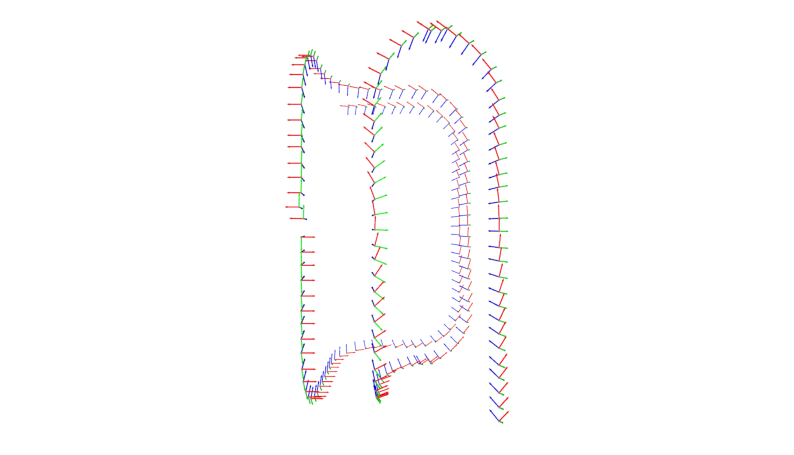

In [4]:
trajectory = [frame.get_transform() for frame in dataset.frames]

vis.visualize_trajectory(trajectory)

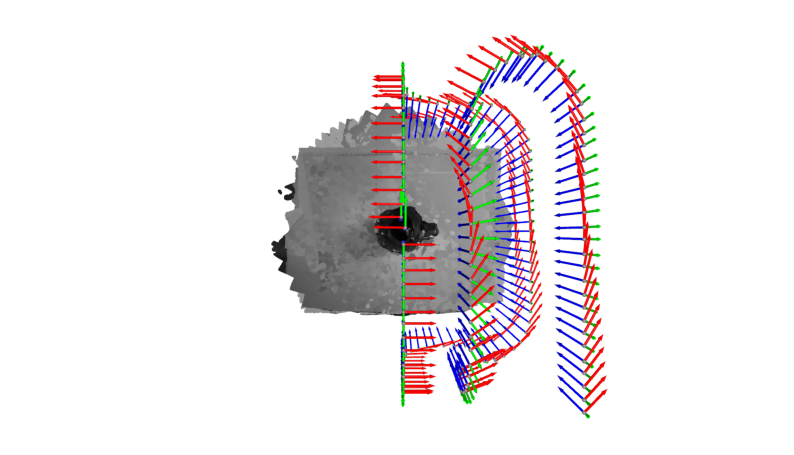

In [5]:
from copy import deepcopy

original_mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
original_mesh.scale(0.05, (0, 0, 0))
meshes = []
for frame in dataset.frames:
    mesh = deepcopy(original_mesh)
    mesh.transform(frame.get_transform())
    meshes.append(mesh)

    color_image = o3d.io.read_image(frame.color_file)
    depth_image = o3d.io.read_image(frame.depth_file)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image, depth_image, depth_scale=1000.0, depth_trunc=0.5)
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(640, 480, 613.688, 614.261, 323.035, 242.229)
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        camera_intrinsic)
    pcd.transform(frame.get_transform())
    
    meshes.append(pcd)

vis.visualize_geometry(meshes)
o3d.visualization.draw_geometries(meshes)

We can see that all camera shots are taken from the right side or above. So we can expect to have gaps in the 3D mesh where we don't have any readings